# Example use of prototype Optimal Predictor Machine with income-dataset

Load required libraries and functions

In [7]:
library('data.table')
library('extraDistr')
library('foreach')
library('png')
source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')
options(repr.plot.width=6*sqrt(2), repr.plot.height=6)




Example creation of preliminary metadata file

In [12]:
guessmetadata(data='train-income_data_example.csv',
              file='preliminary.csv')

The actual metadata file is `meta_income_data_example.csv`

In [13]:
fread('meta_income_data_example.csv', header=TRUE)

variate,domainsize,V1,V2,V3,V4,V5,V6,V7,V8,⋯,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
workclass,7,Federal-gov,Local-gov,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,,⋯,,,,,,,,,,
education,16,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,⋯,,,,,,,,,,
marital_status,7,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,,⋯,,,,,,,,,,
occupation,14,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,⋯,,,,,,,,,,
relationship,6,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,,,⋯,,,,,,,,,,
race,5,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,,,,⋯,,,,,,,,,,
sex,2,Female,Male,,,,,,,⋯,,,,,,,,,,
native_country,42,Cambodia,Canada,China,Columbia,Cuba,Dominican-Republic,Ecuador,El-Salvador,⋯,Portugal,Puerto-Rico,Scotland,South,Taiwan,Thailand,Trinadad&Tobago,United-States,Vietnam,Yugoslavia
income,2,<=50K,>50K,,,,,,,⋯,,,,,,,,,,




Build two agents:
- `opm10`: trained with 10 datapoints
- `opmall`: trained with all datapoints

In [14]:
opm10 <- buildagent(metadata='meta_income_data_example.csv',
                    data=fread('train-income_data_example.csv', header=TRUE)[1:10])

opmall <- buildagent(metadata='meta_income_data_example.csv',
                     data='train-income_data_example.csv')



The agent internally guesses how many training datapoints are necessary to modify its prior information. Here are several sizes with their probabilities:

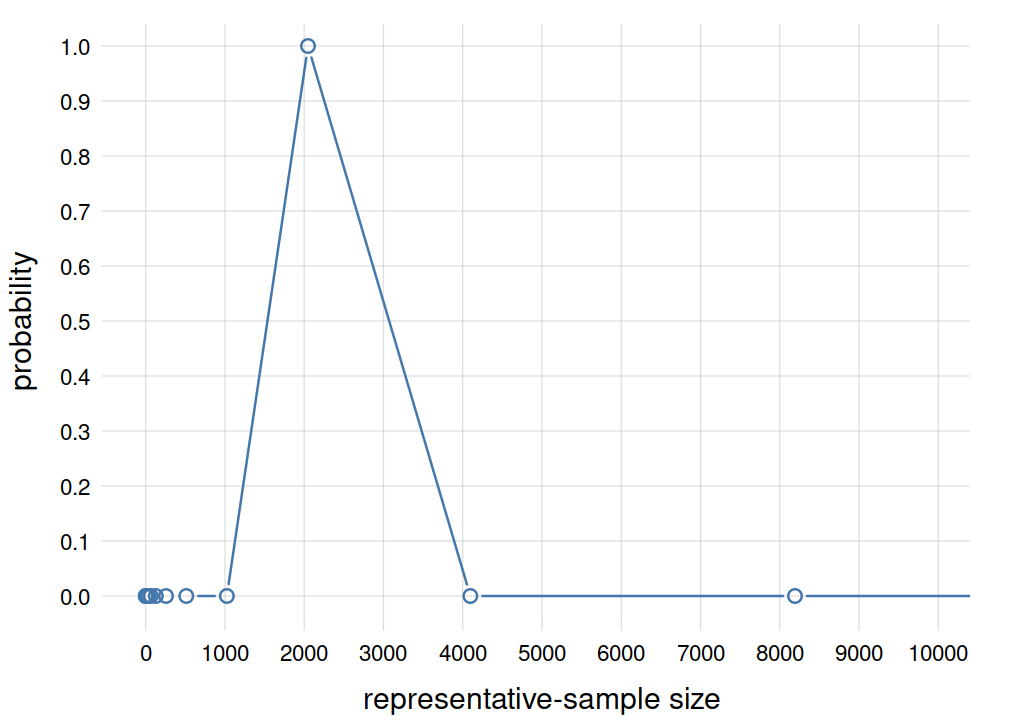

In [15]:
tplot(x=opmall$alphas, y=opmall$palphas, type='b',
      xlim=c(0, 10000), ylim=c(0, NA),
      xlab='representative-sample size', ylab='probability')


# Example applications

## Only predictands, no predictors ("unsupervised-learning mode")

Let the little-trained agent forecast `income` for next unit

In [16]:
print(infer(agent=opm10, predictand='income'))

income
   <=50K     >50K 
0.506288 0.493712 


The agent is internally checking *all possible* population-frequency distributions. It can therefore forecast how its probabilities could change *if more training data were provided*:

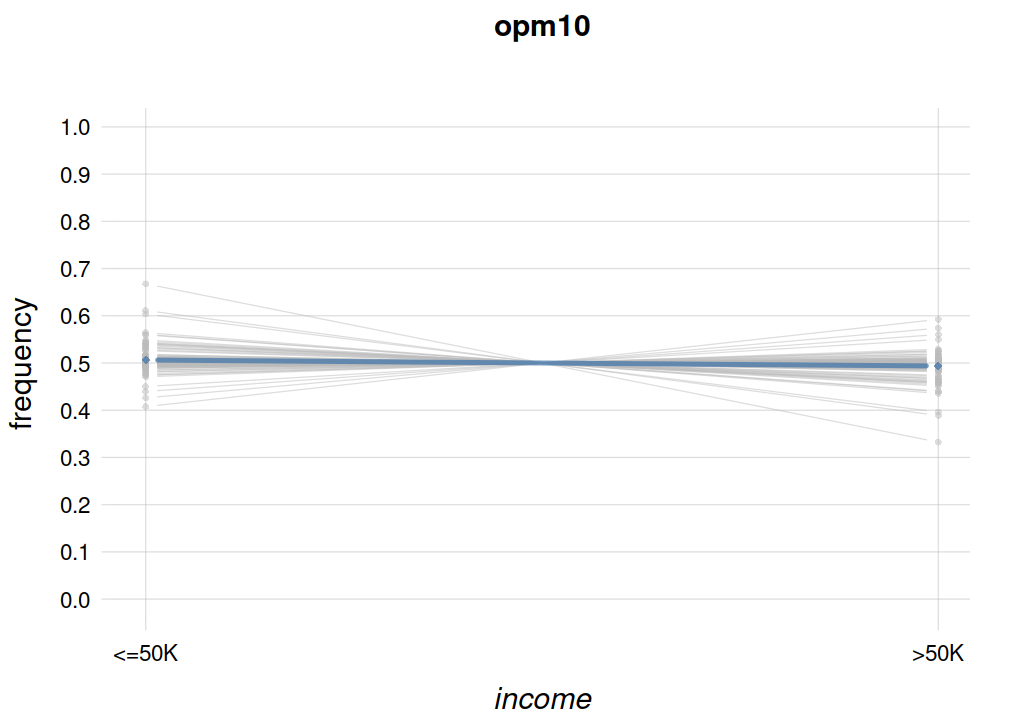

In [17]:
plotFsamples1D(agent=opm10, n=200, predictand='income',
               ylim=c(0,1), main='opm10') # last options are for plotting

Now let's check the inference drawn by the fully-trained agent

In [18]:
print(infer(agent=opmall, predictand='income'))

income
   <=50K     >50K 
0.714318 0.285682 


Also this agent can tell us how much would new training data change its inference:

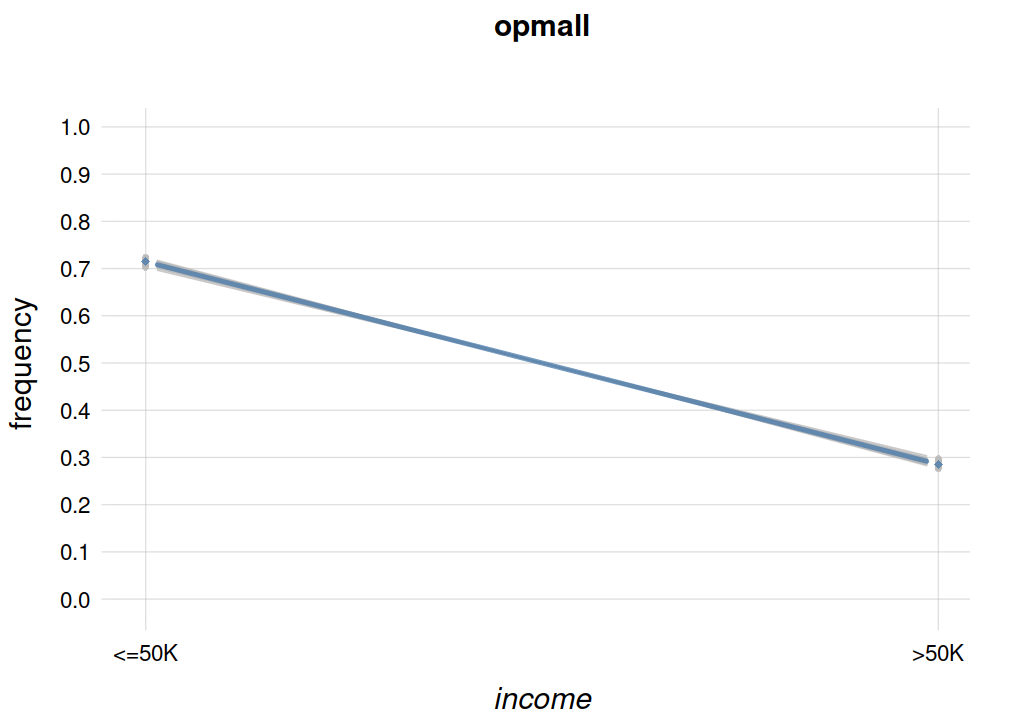

In [19]:
plotFsamples1D(agent=opmall, n=200, predictand='income',
               ylim=c(0,1), main='opmall')

We can draw inferences in the same way for any other variate, e.g. `race`.

This is the inference by the `opm10` agent:

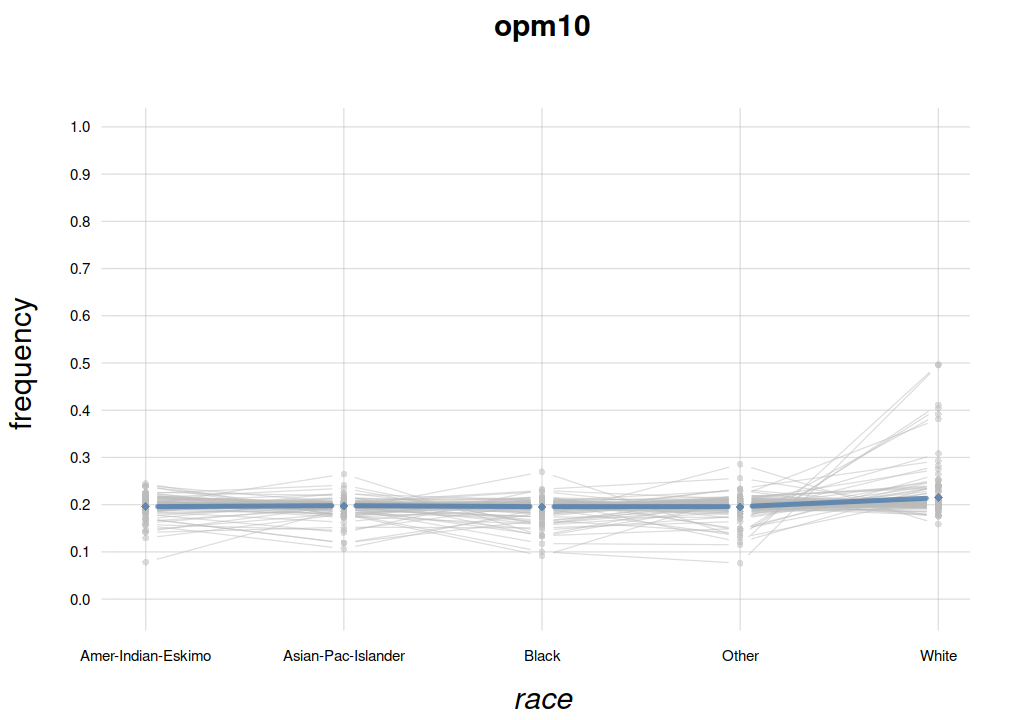

In [20]:
plotFsamples1D(agent=opm10, n=200, predictand='race',
               ylim=c(0,1), main='opm10', cex.axis=0.75)  # last options are for plotting

The agent can also draw inferences about several joint variates.

For instance `race` and `income` (let's show percentages and round to one decimal):

In [29]:
result <- infer(agent=opmall, predictand=c('race', 'income'))

print(round(result*100, 1))

                    income
race                 <=50K >50K
  Amer-Indian-Eskimo   2.3  1.6
  Asian-Pac-Islander   3.4  2.2
  Black                8.5  2.6
  Other                2.1  1.6
  White               55.2 20.5



## Using predictors ("supervised-learning mode")

Suppose we know that `occupation='Exec-managerial'` and `sex='Male'` for the new unit. What can the `income` be?

In [33]:
result <- infer(agent=opmall, predictand='income',
               predictor=list(occupation='Exec-managerial', sex='Male'))

print(round(result*100, 1))

income
<=50K  >50K 
 44.1  55.9 


Also in this case we can ask how much this inference could be changed by new training data:

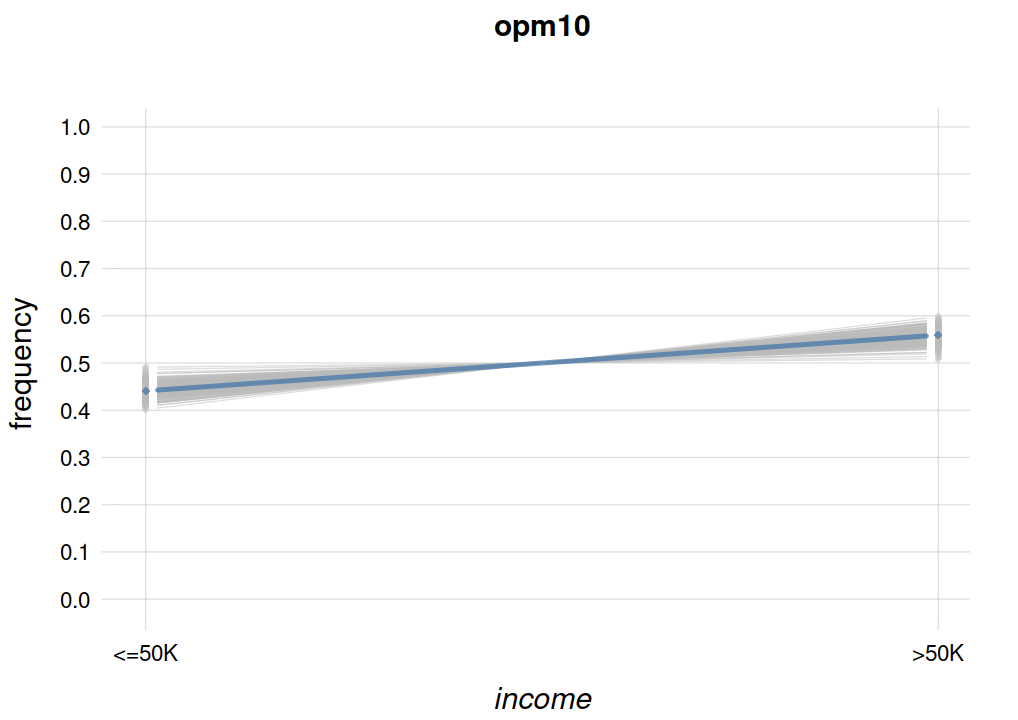

In [27]:
plotFsamples1D(agent=opmall, n=200,
               predictand='income',
               predictor=list(occupation='Exec-managerial', sex='Male'),
               ylim=c(0,1), main='opm10')

## Inverting predictors and predictands ("generative mode")

We can also infer `occupation` and `sex` given any value of `income`

In [37]:
result <- infer(agent=opmall, predictand=c('occupation', 'sex'),
                predictor=list(income='<=50K'))

print(round(result * 100,1))

                   sex
occupation          Female Male
  Adm-clerical         9.4  3.8
  Armed-Forces         0.4  0.4
  Craft-repair         1.1 11.8
  Exec-managerial      4.0  5.0
  Farming-fishing      0.6  3.5
  Handlers-cleaners    1.1  5.0
  Machine-op-inspct    2.3  5.0
  Other-service        6.8  5.6
  Priv-house-serv      0.9  0.4
  Prof-specialty       4.6  4.7
  Protective-serv      0.7  2.1
  Sales                5.2  6.4
  Tech-support         1.7  1.7
  Transport-moving     0.7  5.1


In [38]:
result <- infer(agent=opmall, predictand=c('occupation', 'sex'),
                predictor=list(income='>50K'))

print(round(result * 100,1))

                   sex
occupation          Female Male
  Adm-clerical         3.1  4.1
  Armed-Forces         1.0  1.0
  Craft-repair         1.1  9.4
  Exec-managerial      3.6 16.0
  Farming-fishing      1.0  2.1
  Handlers-cleaners    1.0  1.6
  Machine-op-inspct    1.1  3.1
  Other-service        1.6  1.8
  Priv-house-serv      1.0  1.0
  Prof-specialty       4.8 14.7
  Protective-serv      1.0  3.2
  Sales                1.8 10.1
  Tech-support         1.5  3.4
  Transport-moving     1.1  3.7


Also in this case we can assess how much these probabilities would change with more training data. The function `rF()` is used for this:

In [40]:
freqsamples <- rF(n=1000, agent=opmall, predictand=c('occupation', 'sex'),
                  predictor=list(income='>50K'))
variability <- apply(freqsamples,
                     c('occupation','sex'), # which dimensions to apply
                     sd) # function to apply to those dimensions
##
## Possible variation (sd) with new training data:
print(round(variability * 100, 1)) # round to one decimal

                   sex
occupation          Female Male
  Adm-clerical         0.3  0.3
  Armed-Forces         0.2  0.2
  Craft-repair         0.2  0.5
  Exec-managerial      0.3  0.6
  Farming-fishing      0.2  0.2
  Handlers-cleaners    0.2  0.2
  Machine-op-inspct    0.2  0.3
  Other-service        0.2  0.2
  Priv-house-serv      0.2  0.2
  Prof-specialty       0.3  0.6
  Protective-serv      0.2  0.3
  Sales                0.2  0.5
  Tech-support         0.2  0.3
  Transport-moving     0.2  0.3


## Calculating relevance of predictors

The agent can calculate the mutual information (measured in shannons) between any two sets of variates `A` and `B` of our choice, with the function `mutualinfo(probs, A, B)`. The joint probabilities for `A`,`B` are calculated with `infer()`.

For instance, what is the mutual information between `occupation` and `marital status`? The mutual information in this case can be anywhere between 0 Sh and 1 Sh 

(We print the result with 4 significant digits)

In [44]:
probs <- infer(agent=opmall, predictand=c('occupation', 'marital_status'))

result <- mutualinfo(probs=probs, A='occupation', B='marital_status')

print(signif(result, 4))

[1] 0.08278


Let’s consider a scenario where, in order to save resources, we can use *only one* variate in order to infer the income. Which of the other variates should we prefer? We can calculate the mutual information between each of them and `income`:

In [47]:
## list of all variates
variates <- names(dimnames(opmall$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'income']

## prepare vector to contain the mutual information
relevances <- numeric(length(predictors))
names(relevances) <- predictors

## calculate joint probability and then mutual information (shannons)
## of 'income' and another variate
for(var in predictors){
    probs <- infer(agent=opmall, predictand=c('income',var))
    relevances[var] <- mutualinfo(probs=probs, A='income', B=var)
}

## output the mutual informations in decreasing order
print(round(sort(relevances, decreasing=TRUE), 4))

marital_status   relationship      education     occupation      workclass 
        0.1007         0.0905         0.0633         0.0551         0.0300 
native_country            sex           race 
        0.0193         0.0146         0.0087 


The most informative *single* predictor is `marital_status`, the least informative is `race`.